# Fitting resonators with GARFIELD for coupler

In [152]:
import os, sys
from functools import partial
import numpy as np
from scipy.constants import c
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../garfield/')
from Genetic_algorithm import *
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm
from scipy.signal import find_peaks

%matplotlib ipympl

In [153]:
# Importing impedance data
data_impedance = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/COUPLER/5FerritesCoupler.txt', comments='#', delimiter='\t')

# Frequency

freq_data = data_impedance[:,0]*1e9

# Impedance

imp_data = np.abs(data_impedance[:,1])# + 1j*data_impedance[:,2])

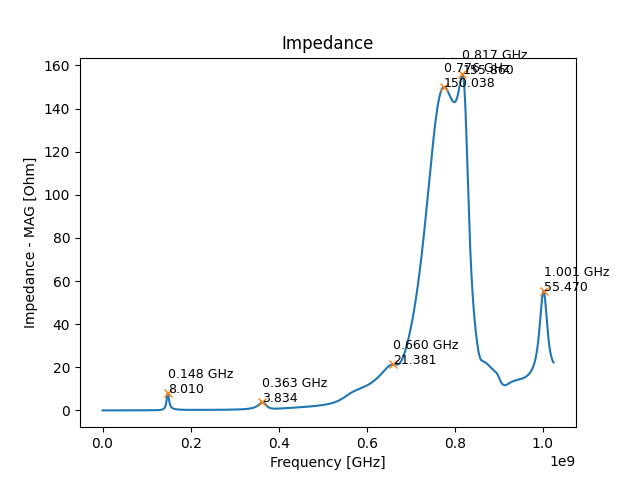

array([14467, 35471, 64446, 75748, 79803, 97803])

In [154]:
plt.figure()

peaks, peaks_height = find_peaks(imp_data, height=2, threshold=None)
for i, (peak, height) in enumerate(zip(peaks, peaks_height['peak_heights'])):
    plt.text(freq_data[peak], imp_data[peak], f'{freq_data[peak]/1e9:.3f} GHz\n{height:.3f}', fontsize=9)

plt.plot(freq_data, imp_data)
plt.plot(freq_data[peaks], (imp_data[peaks]), "x")
plt.xlabel('Frequency [GHz]')
plt.ylabel('Impedance - MAG [Ohm]')
plt.title('Impedance')


plt.show()

peaks

In [155]:
#Number of resonators
Nres = 6 # can be changed to see what happens

#wake_length = 100 # simulated wake length in [m], can be 10,200, 1000, 2000, 4000
frequency_data = freq_data #frequencies in Hz
impedance_data = np.array(data_impedance[:,1])# + \
                          #1j*data_impedance[:,2])

time_data = np.zeros(1)
wake_data = np.zeros(1)
#supply the wake length to the resonator formula to use the 
#partially decayed wake variant 

n_Resonator_longitudinal_imp = partial(n_Resonator_longitudinal_imp)

parameterBounds = [(1, 200), (1,50), (0.145e9, 0.152e9),
                    (1, 200), (1,50), (0.355e9, 0.375e9),
                    (1, 200), (1,50), (0.65e9, 0.67e9),
                    (10, 200), (1,50), (0.77e9, 0.78e9),
                    (10, 200), (1,50), (0.81e9, 0.82e9),
                    (10, 200), (1,50), (0.99, 1.01e9)]
 # Bounds: [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].


### Running the GA

In [156]:
%%time
GA_model_scipy_1 = GeneticAlgorithm(frequency_data, 
                                  impedance_data, 
                                  time_data, 
                                  wake_data, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredErrorReal, #sumOfSquaredErrorReal else...
                                  fitFunction=n_Resonator_longitudinal_imp,
                                 )

GA_model_scipy_1.run_geneticAlgorithm(maxiter=30000, 
                                    popsize=25, 
                                    tol=0.001, 
                                    mutation=(0.3, 0.8),
                                    crossover_rate=0.5
                                   )
print(GA_model_scipy_1.warning)

Progress: [####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.36e+00        |      20.32       |    1.480e+08     
    2     |        3.81e+00        |      33.87       |    3.626e+08     
    3     |        6.91e+00        |       4.59       |    6.502e+08     
    4     |        1.46e+02        |       9.75       |    7.700e+08     
    5     |        9.77e+01        |      30.95       |    8.166e+08     
    6     |        4.82e+01        |      37.49       |    1.001e+09     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 1min 41s, sys: 22 s, total: 2min 3s
Wall time: 19min 32s


In [157]:
%%time
GA_model_scipy_1.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.91e+00        |      21.98       |    1.483e+08     
    2     |        3.27e+00        |      23.70       |    3.619e+08     
    3     |        7.06e+00        |       5.81       |    6.265e+08     
    4     |        1.46e+02        |       9.69       |    7.688e+08     
    5     |        9.96e+01        |      29.54       |    8.161e+08     
    6     |        4.79e+01        |      36.37       |    1.001e+09     
----------------------------------------------------------------------
CPU times: user 31.7 s, sys: 205 ms, total: 31.9 s
Wall time: 32 s


10.208881377553796


/tmp/malthera/ipykernel_109270/714898634.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax0 = plt.subplots(1, 1, figsize=(12,5))


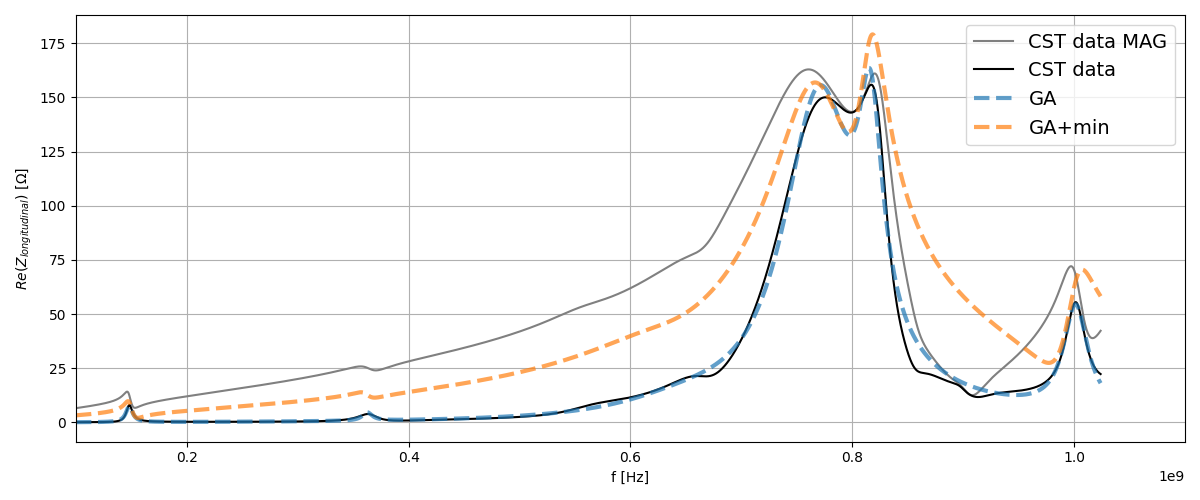

In [158]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy_1.frequency_data, np.abs(data_impedance[:,1] + 1j*data_impedance[:,2]), "grey", label='CST data MAG')

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(GA_model_scipy_1.geneticParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='GA', alpha=0.7)

ax0.plot(GA_model_scipy_1.frequency_data, np.abs(GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(GA_model_scipy_1.minimizationParameters.reshape(-1, 3))))),
         lw = 3, linestyle='--', label='GA+min', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()
print(np.mean((np.abs(imp_data) - (GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(GA_model_scipy_1.geneticParameters.reshape(-1, 3)))).real))**2))

In [ ]:
#Number of resonators
Nres = 2 # can be changed to see what happens

#wake_length = 100 # simulated wake length in [m], can be 10,200, 1000, 2000, 4000
frequency_data = data_impedance[:int(len(data_impedance)*0.4),0]*1e9 #frequencies in Hz
impedance_data = np.array(data_impedance[:int(len(data_impedance)*0.4),1])# + \
                          #1j*data_impedance[:int(len(data_impedance)*0.4),2])

time_data = np.zeros(1)
wake_data = np.zeros(1)

n_Resonator_longitudinal_imp = partial(n_Resonator_longitudinal_imp)#, wake_length=wake_length)

parameterBounds = [(1, 200), (1,50), (0.145e9, 0.152e9),
                    (1, 200), (1,50), (0.355e9, 0.365e9)]
 # Bounds: [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].

In [146]:
%%time
GA_model_scipy_2 = GeneticAlgorithm(frequency_data, 
                                  impedance_data, 
                                  time_data, 
                                  wake_data, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredErrorReal,
                                  fitFunction=n_Resonator_longitudinal_imp,
                                 )

GA_model_scipy_2.run_geneticAlgorithm(maxiter=30000, 
                                    popsize=25, 
                                    tol=0.0001, 
                                    mutation=(0.3, 0.8),
                                    crossover_rate=0.5
                                   )
print(GA_model_scipy_2.warning)

Progress: [######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.88e+00        |      20.95       |    1.483e+08     
    2     |        3.51e+00        |      11.95       |    3.619e+08     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 6.7 s, sys: 1.99 s, total: 8.7 s
Wall time: 12.3 s


In [147]:
%%time
GA_model_scipy_2.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.88e+00        |      20.96       |    1.483e+08     
    2     |        3.51e+00        |      11.95       |    3.619e+08     
----------------------------------------------------------------------
CPU times: user 452 ms, sys: 0 ns, total: 452 ms
Wall time: 453 ms


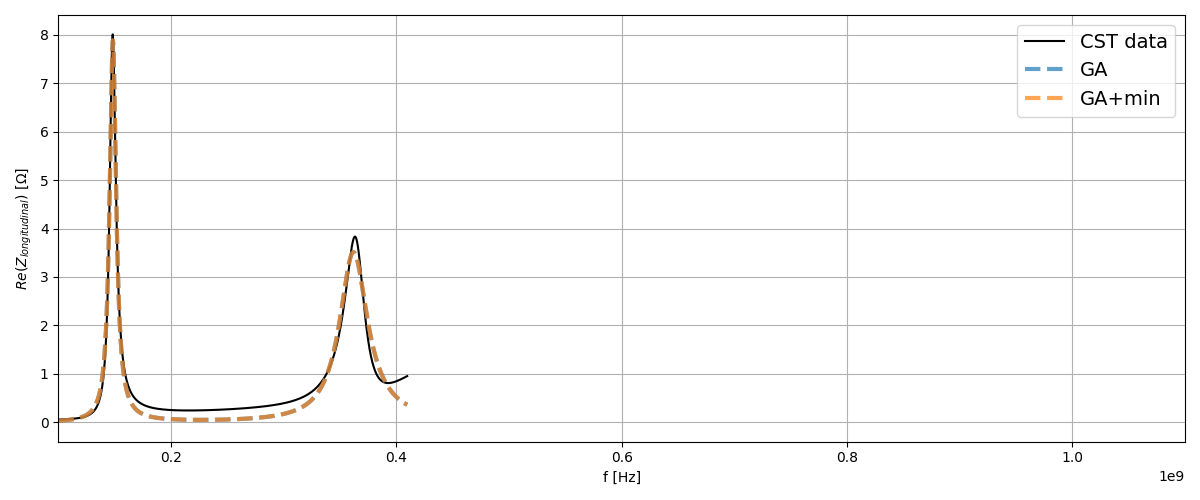

In [148]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy_2.frequency_data, GA_model_scipy_2.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy_2.frequency_data, GA_model_scipy_2.fitFunction(GA_model_scipy_2.frequency_data, dict(enumerate(GA_model_scipy_2.geneticParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='GA', alpha=0.7)

ax0.plot(GA_model_scipy_2.frequency_data, GA_model_scipy_2.fitFunction(GA_model_scipy_2.frequency_data, dict(enumerate(GA_model_scipy_2.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='GA+min', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

In [151]:
sumofGA = np.concatenate((GA_model_scipy_2.minimizationParameters.reshape(-1, 3), GA_model_scipy_1.minimizationParameters.reshape(-1, 3)), axis=0)

print(sumofGA)

#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(sumofGA))),
         lw = 3, linestyle='--', label='GA', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

AttributeError: 'NoneType' object has no attribute 'reshape'